# Bootcamp 2023 - regresja

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, BayesianRidge, LassoLars, TweedieRegressor, Ridge, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.datasets import fetch_openml, fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

## 1. Przygotowanie datsetu

In [ ]:
# fetchujemy datset - obiekt scikitlearn
data = fetch_california_housing(as_frame=True)
print(data.DESCR)

In [ ]:
# konwertujemy obiekt sklearn do pandasa 
print(type(data))
data = data.frame
print(type(data))

In [ ]:
data.head()

In [ ]:
data.info()

In [ ]:
data.describe()

### Co to jest [korelacja](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)?

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, ax=ax)
# plt.show()

### [Boxplot](https://builtin.com/data-science/boxplot)

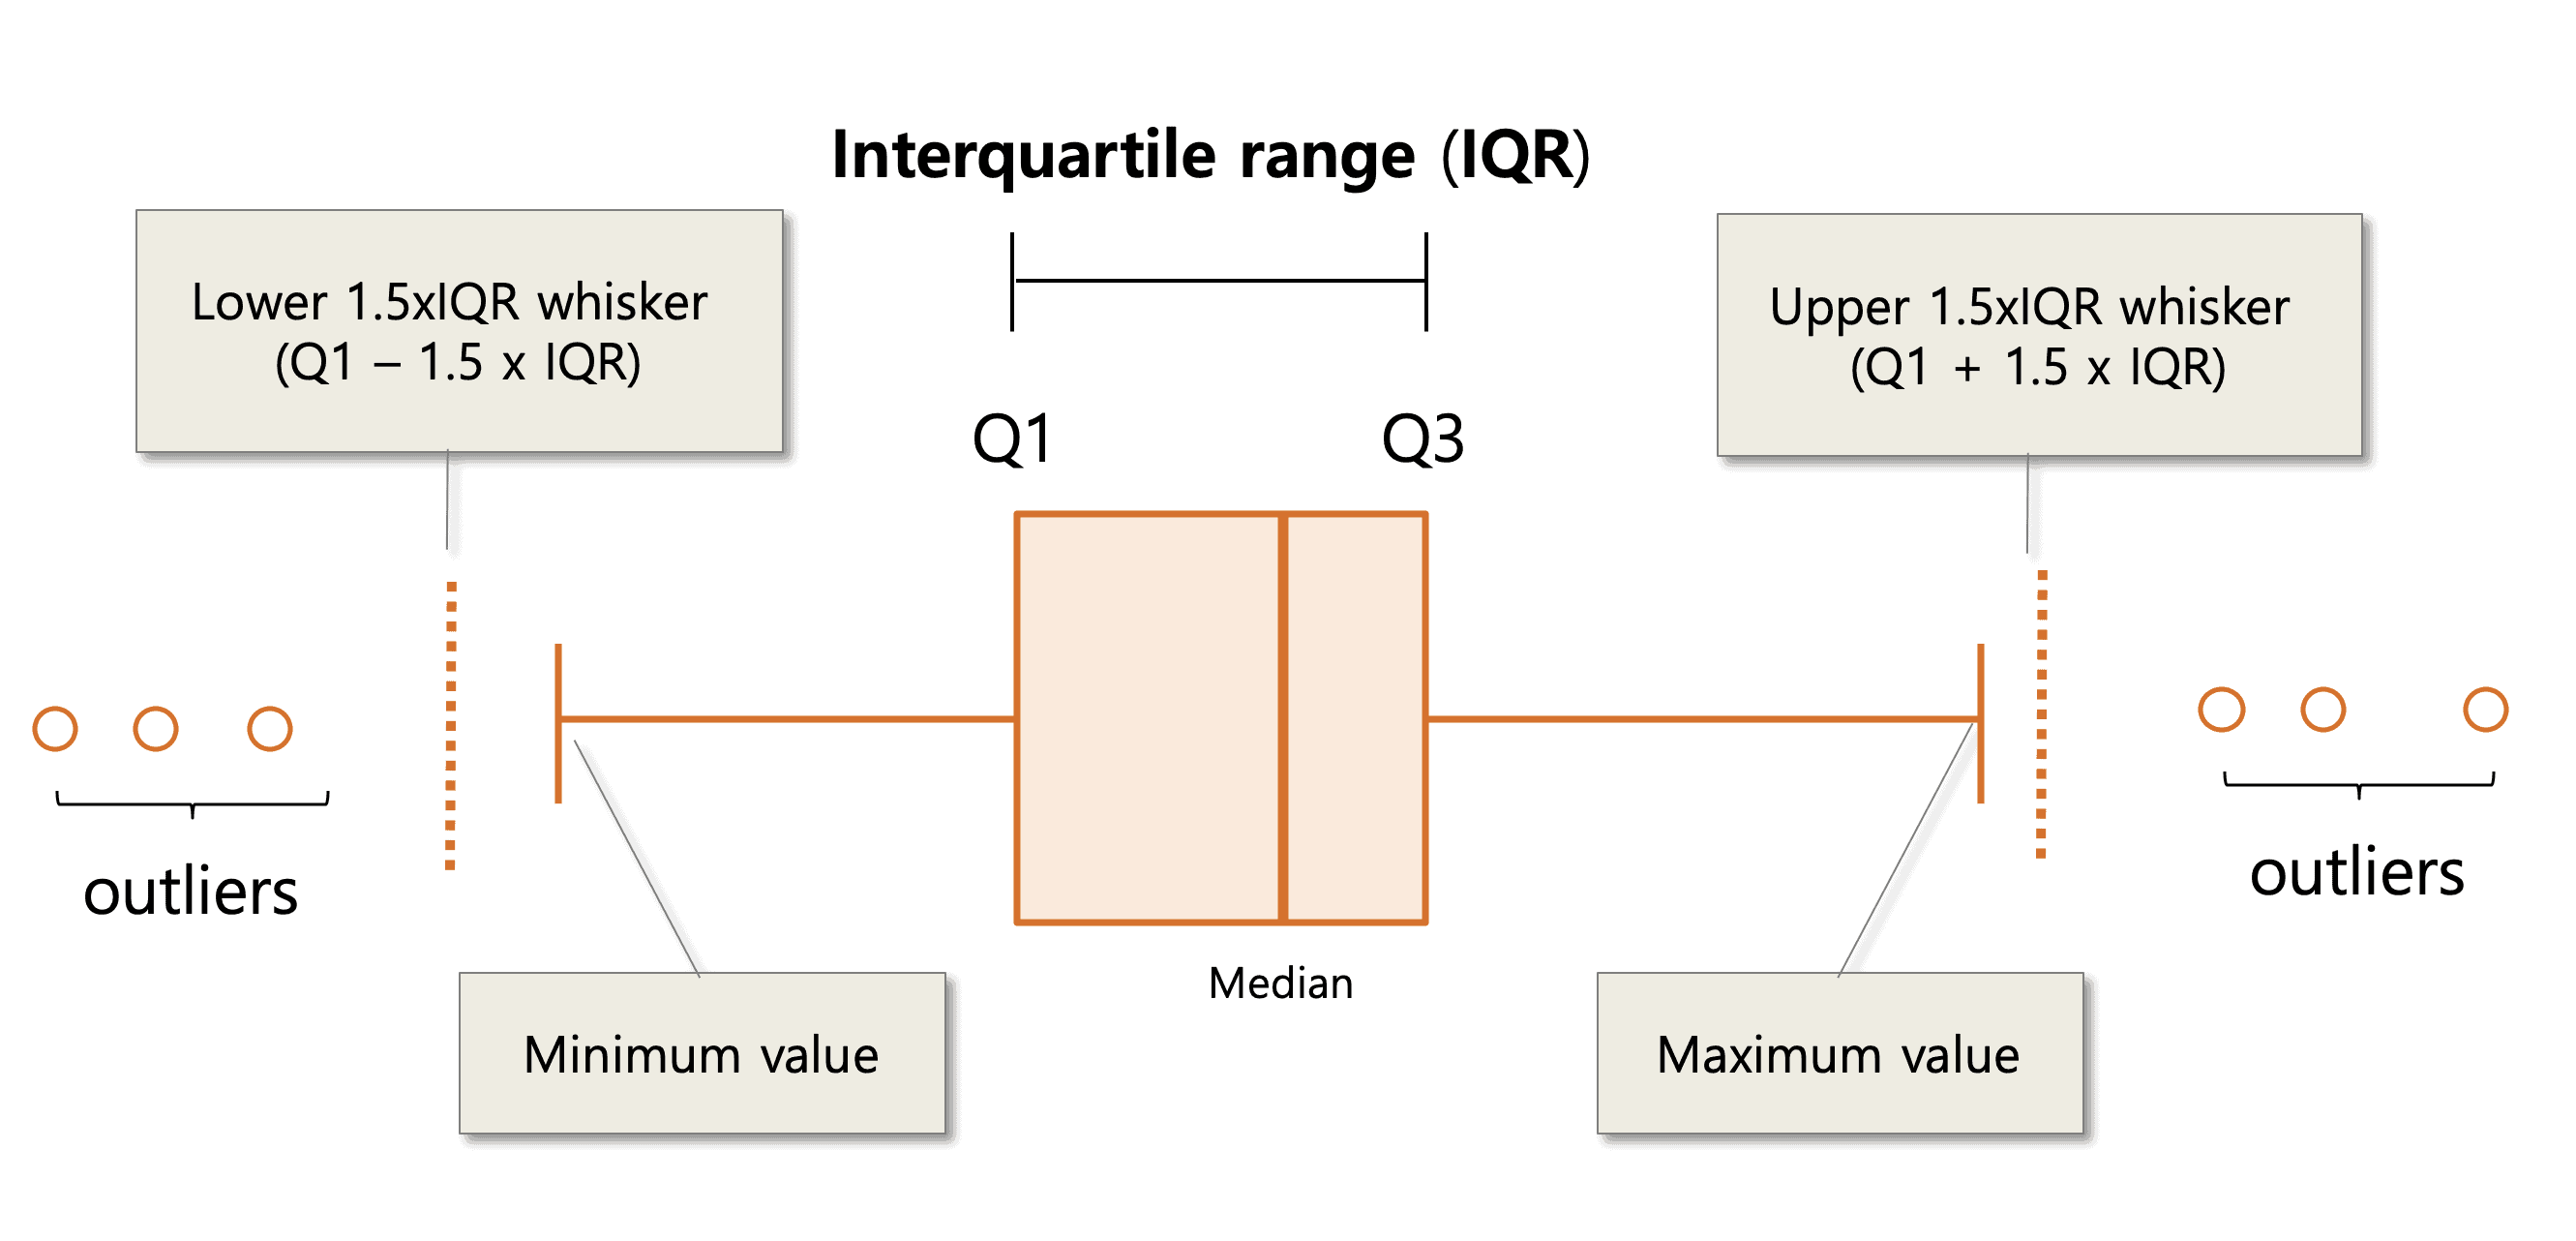

In [ ]:
# dzielimy dane na target i features
target = 'MedHouseVal'
features = [col for col in data.columns.to_list() if col != target]

# dla każdego feature rysujemy boxplot
fig, axis = plt.subplots(2, data.shape[1]//2, figsize=[20, 10])
idx=0;
axis=axis.flatten()
for feature in features:
    sns.boxplot(y=feature, data=data[[feature]], ax=axis[idx])
    idx+=1
        
plt.tight_layout()
plt.show()

In [ ]:
# wyrzucamy outlaiery
def remove_outliers(df,columns,n_std):
    for col in columns:
        mean = df[col].mean()
        sd = df[col].std()
        df = df[(df[col] <= mean+(n_std*sd))]
        
    return df

In [ ]:
data = remove_outliers(data, features, 3)

In [ ]:
fig, axis = plt.subplots(2, data.shape[1]//2, figsize=[20, 10])
idx=0;
axis=axis.flatten()
for feature in features:
    sns.boxplot(y=feature, data=data[[feature]], ax=axis[idx])
    idx+=1
        
plt.tight_layout()
plt.show()

In [ ]:
# dla każdej features rysujemy zależność od targetu
fig, axis = plt.subplots(data.shape[1]//2, 2, figsize=[20, 40])
idx=0;
axis=axis.flatten()
for feature in features:
    data.plot(y=target, x=feature, kind="scatter", ax=axis[idx])
    idx+=1
        
plt.tight_layout()
plt.show()

## 2. Model liniowy

- [Dokumentacja sklearn](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares)

In [ ]:
def build_model(data, model, train_test_ratio, chosen_features, target, random_state=45):
    
    # dzielimy na train i test
    data_train, data_test = train_test_split(data, test_size=train_test_ratio, random_state=random_state)
    X_train, X_test = data_train[chosen_features], data_test[chosen_features]
    y_train, y_test = data_train[target], data_test[target]
    
    # cała regresja dzieje się tutaj
    model.fit(X_train, y_train)
    
    # przewidujemy wartość dla danych testowych
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # liczymy MSE
    MSE_train = mean_squared_error(y_train, y_pred_train)
    MSE_test = mean_squared_error(y_test, y_pred_test)
    print('MSE on training data:', MSE_train)
    print('MSE on test data:', MSE_test)
    
    return model, MSE_test

In [ ]:
# model liniowy z jedną zmienną
chosen_features = ['MedInc']
train_test_ratio=0.2

model, MSE= build_model(data, LinearRegression(), train_test_ratio, chosen_features, target)

# tutaj robię dictionary żeby później móc porównać modele
model_dict = {"linear_1": MSE}

In [ ]:
# można sobie zwizualizować
plt.figure(figsize=(10, 10))
sns.scatterplot(x='MedInc', y="MedHouseVal", data=data[['MedInc','MedHouseVal']])
tmp_x = np.array([[data['MedInc'].min(),],[data['MedInc'].max(),]])
tmp_y = model.predict(tmp_x)
plt.plot(tmp_x, tmp_y, color='r')
plt.show()

In [ ]:
# model liniowy z paroma zmiennymi które wydają się nam najważniejsze

chosen_features = ['MedInc', 'AveRooms', 'AveBedrms', 'AveOccup']

model, MSE = build_model(data, LinearRegression(), train_test_ratio, chosen_features, target)

model_dict["linear_2"] = MSE

In [ ]:
# model liniowy ze wszystkimi featurami

chosen_features = features

model, MSE = build_model(data, LinearRegression(), train_test_ratio, chosen_features, target)

model_dict["linear_3"] = MSE

## 3. Model wielomianowy

- [PolynomialFeatures() - dokumentacja sklearn](https://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions)
- [make_pipeline - dokumentacja sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html)

### 3. 1 Co robi PolynomialFeatures()?

In [ ]:
example = np.arange(6).reshape(3, 2)
print(example)

In [ ]:
poly2 = PolynomialFeatures(2) # stopien wielomianu
print(poly2.fit_transform(example))

In [ ]:
poly3 = PolynomialFeatures(3) 
print(poly3.fit_transform(example))

### 3.2 Co robi make_pipeline()?

In [ ]:
regression_model = LinearRegression()
example = np.array([[2, 3, 36], [5, 4, 160], [3, 2, 24]])
X = example[:, 0:2]
Y=example[:, 2]
print(X)
print(Y)

In [ ]:
#najpierw transformujemy input tak jak na górze
X_poly = poly3.fit_transform(X)

#potem na nowym inpucie robimy regresje
regression_model.fit(X_poly, Y)

#wyświetl wpolczynniki ktore policzył model regresji
print(regression_model.coef_)

In [ ]:
# dwa modele nałożone na siebie
pipe = make_pipeline(PolynomialFeatures(3),LinearRegression())
pipe.fit(X, Y)

# możemy zobaczyć jakie modele są w środku
print(pipe.named_steps)

In [ ]:
# mamy dostep do kazdego modelu z pipeline; patrzymy jakie współczynniki policzył model regresji (spoiler: są takie same)
print(pipe.named_steps['linearregression'].coef_)

### 3.3 Przykłady 

In [ ]:
# model wielomianowy o stopniu 2
degree=2

model, MSE = build_model(data, make_pipeline(PolynomialFeatures(degree),LinearRegression()), train_test_ratio, chosen_features, target)

model_dict["poly_deg2"] = MSE

In [ ]:
# model wielomianowy o stopniu 3
degree=3

model, MSE = build_model(data, make_pipeline(PolynomialFeatures(degree),LinearRegression()), train_test_ratio, chosen_features, target)

model_dict["poly_deg3"] = MSE

In [ ]:
# model wielomianowy o stopniu 4 
degree=5
model, MSE = build_model(data, make_pipeline(PolynomialFeatures(degree),LinearRegression()),
                         train_test_ratio, chosen_features, target)

model_dict["poly_deg4"] = MSE

## 4. Modele z regularyzacją

- [Lasso - dokumentacja sklearn](https://scikit-learn.org/stable/modules/linear_model.html#lasso)
- [Ridge - dokumentacja sklearn](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression-and-classification)

In [ ]:
model, MSE = build_model(data, Ridge(alpha=0.2), train_test_ratio, chosen_features, target)
model_dict["ridge"] = MSE

In [ ]:
model, MSE = build_model(data, Lasso(alpha=0.1), train_test_ratio, chosen_features, target)
model_dict["lasso"] = MSE

## 5*. Inne modele regresyjne

Poza dopasowywaniem parametrów w funkcjach matematycznych, można dopasowywać je jako parametry dystrybucji w statystyce. Żeby dobrze zrozumieć poniższe przykłady, trzeba mieć sporą wiedzę ze statystyki i algebry, ale warto wiedzieć że takie coś istnieje.

- [Lasso LARS](https://en.wikipedia.org/wiki/Least-angle_regression)
- [Bayesian Ridge](https://towardsdatascience.com/how-to-build-a-bayesian-ridge-regression-model-with-full-hyperparameter-integration-f4ac2bdaf329)
- [Random Forests Regression](https://towardsdatascience.com/random-forest-regression-5f605132d19d) <-to najbardziej polecam przeczytać, zdecydowanie używane najczęściej z tych przykładów

In [ ]:
model, MSE = build_model(data, LassoLars(alpha=.1, normalize=False), train_test_ratio, chosen_features, target)
model_dict["lassoLARS"] = MSE

In [ ]:
model, MSE = build_model(data, BayesianRidge(), train_test_ratio, chosen_features, target)
model_dict["bayesian_ridge"] = MSE

In [ ]:
model, MSE = build_model(data, RandomForestRegressor(), train_test_ratio, chosen_features, target)
model_dict["radom_forest"] = MSE

## 6. Wnioski

In [ ]:
heights =  model_dict.values()
labels = model_dict.keys()
plt.bar(range(len(labels)), heights)
plt.xticks(range(len(labels)), labels, rotation=90)
plt.show()